# A Large Fish Classification Project With ANN

**Developed by İzzet Özdemir for Final Project of Deep Learning Bootcamp of Global AI Hub**

# 1.Libraries

## Step1 : We install the python libraries we need

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import plot_model

# 2.Data Preprocessing

## Step2: We establish the dataset connection

In [3]:
directory = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
classes = [i for i in os.listdir(directory) if '.' not in i]
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

# 3.Exploratory Data Analysis (EDA)

## Step3 : We reach our data set

In [4]:
label = []
path = []

for dir_name, _,filenames in os.walk(directory):
    for filename in filenames:
        if dir_name.split()[-1]!='GT':
            if os.path.splitext(filename)[-1]=='.png':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name,filename))
                
data = pd.DataFrame(columns=['path','label'])
data['path'] = path
data['label'] = label

In [5]:
data

path            label
0     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
...                                                 ...              ...
8995  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8996  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream

[9000 rows x 2 columns]

## Step4: We are showing our first record

In [6]:
data.path[0]

'/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png'

## Step5 : We find the count of each of our fish classes

In [7]:
data.label.value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

## Step6 : We show the sample picture of each of our fish classes

In [8]:
cn = 0
plt.figure(figsize=(20,20))
for unique_label in data['label'].unique():
    plt.subplot(3,3,cn+1)
    plt.imshow(plt.imread(data[data['label'] == unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    cn+=1

## Step7 : Let's just show some shrimp

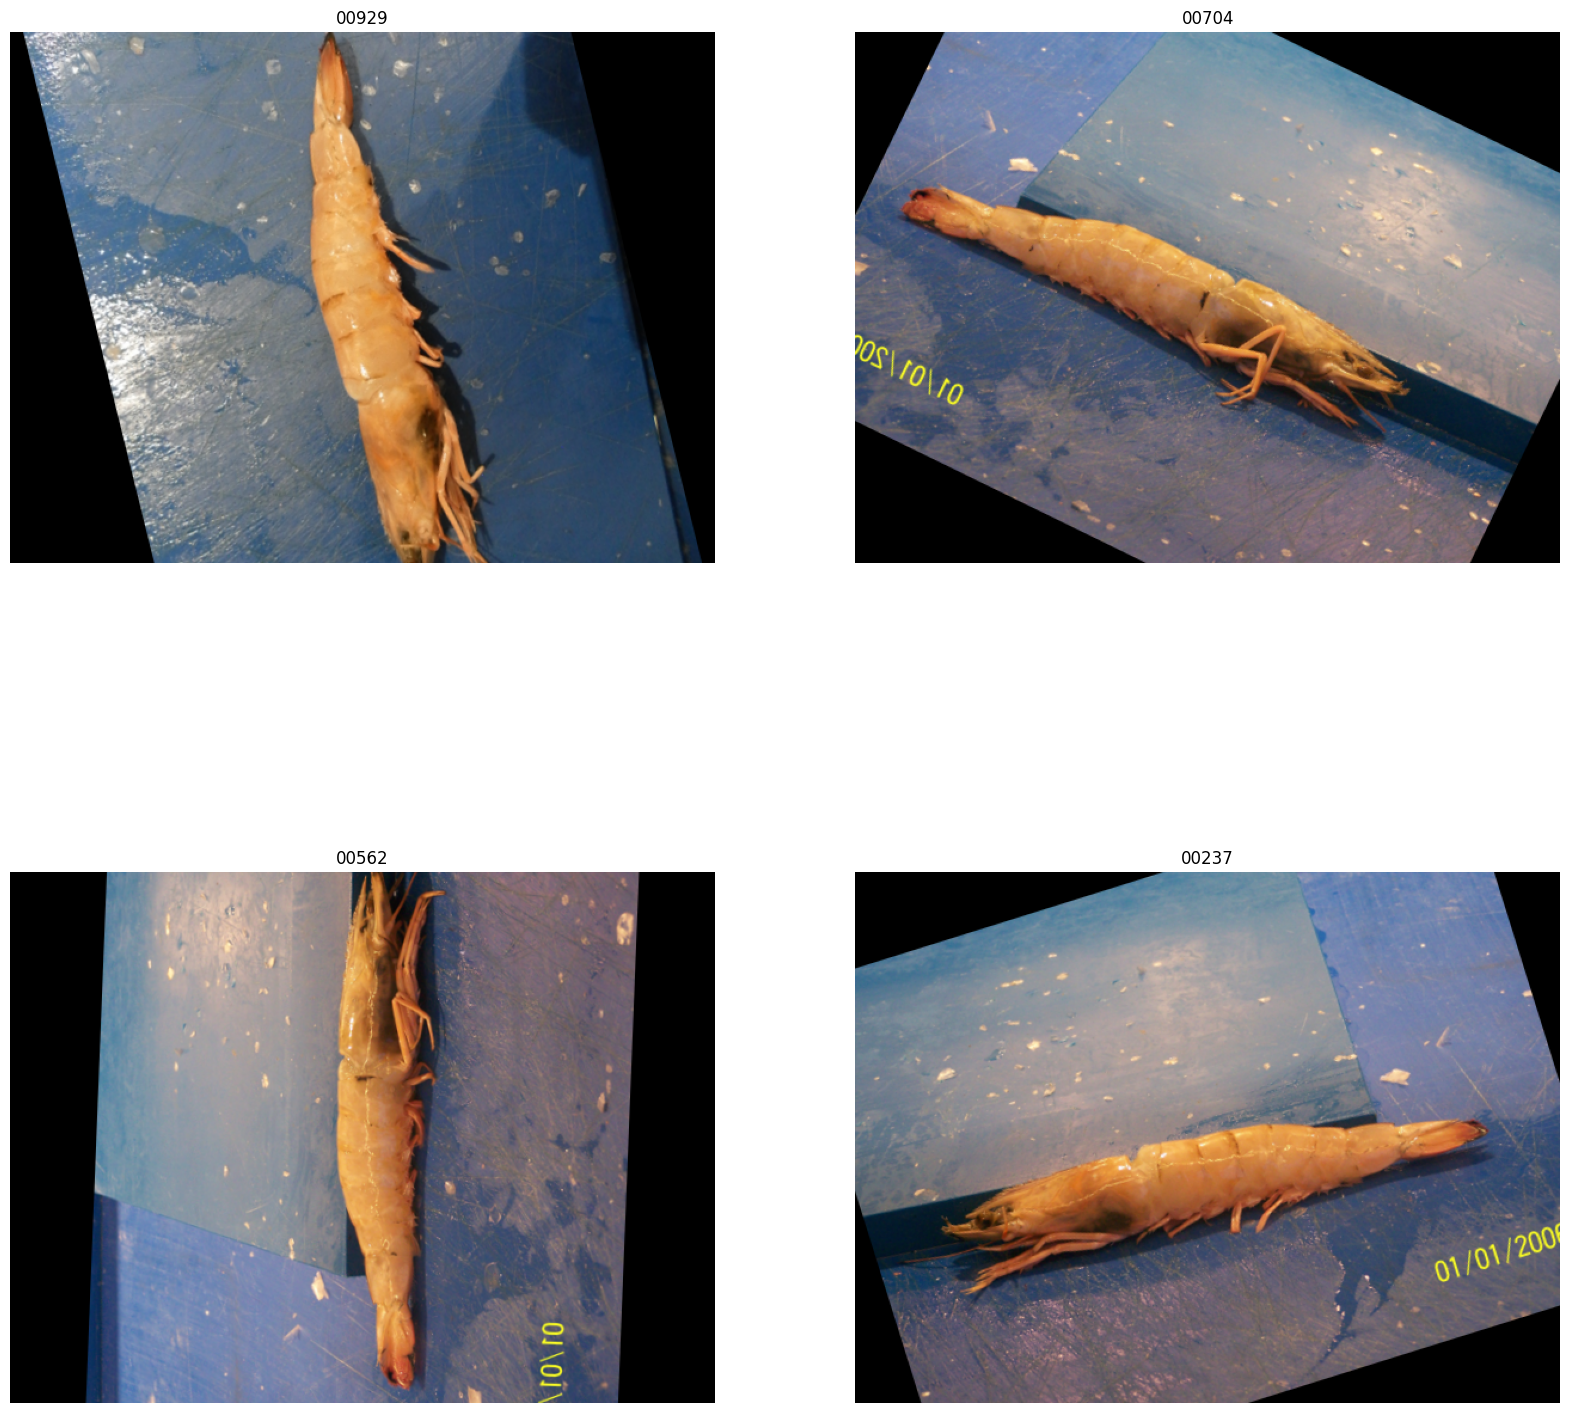

In [9]:
shrimps = data[data['label'] == 'Shrimp'].path.iloc[0:4]

cn = 0
plt.figure(figsize=(20,20))
for shrimp in shrimps:
    plt.subplot(int(np.sqrt(len(shrimps))),int(np.sqrt(len(shrimps))),cn+1)
    plt.imshow(plt.imread(shrimp))
    plt.title(shrimp[-9:-4])
    plt.axis('off')
    cn+=1

# 4.Dataset Split

## Step8 : We split our dataset as %80 train set and %20 test set

In [10]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=28)

# 5.Data Streams

## Step9 : We create data stream to more efficient for memory usage and obstruct to overfitting.

#### It creates a data stream (generator) to be used in the model's training process by loading training images and labels from the DataFrame. In this way, memory usage becomes more efficient when working with large data sets.

In [11]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=28,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=28,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [13]:
print("Index of Each Class :")
train_images.class_indices

Index of Each Class :


{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

# 6.Modelling of ANN

In [14]:
model = Sequential([
    Flatten(input_shape=(128, 128, 3)),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(len(train_images.class_indices), activation='softmax')
])

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,335,305 (96.65 MB)

 Trainable params: 25,333,513 (96.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [15]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=10,restore_best_weights=True)

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.00001)

# 7.Training The Model

In [17]:
history = model.fit(train_images,epochs=20,validation_data=val_images,callbacks=[early_stopping, reduce_lr],verbose=1)

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 167s 882ms/step - accuracy: 0.3691 - loss: 1.9249 - val_accuracy: 0.6500 - val_loss: 1.0485 - learning_rate: 0.0010
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 115s 623ms/step - accuracy: 0.6616 - loss: 0.9831 - val_accuracy: 0.7917 - val_loss: 0.6453 - learning_rate: 0.0010
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 114s 621ms/step - accuracy: 0.7791 - loss: 0.6363 - val_accuracy: 0.8396 - val_loss: 0.5688 - learning_rate: 0.0010
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 143s 627ms/step - accuracy: 0.8282 - loss: 0.4723 - val_accuracy: 0.8583 - val_loss: 0.6123 - learning_rate: 0.0010
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 115s 625ms/step - accuracy: 0.8639 - loss: 0.3786 - val_accuracy: 0.8799 - val_loss: 0.7907 - learning_rate: 0.0010
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 114s 621ms/step - accuracy: 0.9006 - loss: 0.2952 - val_accuracy: 0.8944 - val_loss: 1.3144 - learning_rate: 0.0010
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 114s 618ms/step - accura

In [18]:
test_loss, test_accuracy = model.evaluate(test_images)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 576ms/step - accuracy: 0.9676 - loss: 0.2970
Test Loss: 0.3761
Test Accuracy: 0.9694


In [19]:
plot_model(model, show_shapes = True)

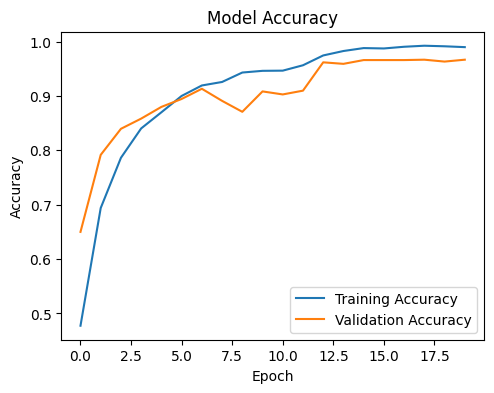

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

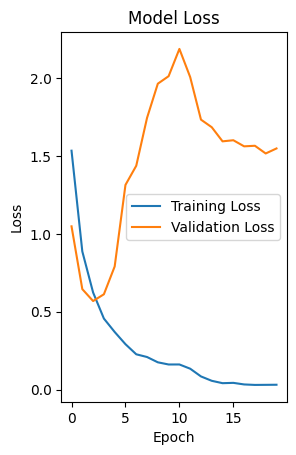

In [21]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 8.Prediction of Model

In [22]:
predictions = model.predict(test_images, steps=len(test_images))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_images.classes

57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 375ms/step


In [23]:
class_labels = list(test_images.class_indices.keys())

In [24]:
predict_data = pd.DataFrame({
    'label': [class_labels[i] for i in true_classes],
    'pred': [class_labels[i] for i in predicted_classes]
})

In [25]:
print(f"Accuracy Score: {accuracy_score(predict_data['label'], predict_data['pred'])}")

Accuracy Score: 0.9694444444444444


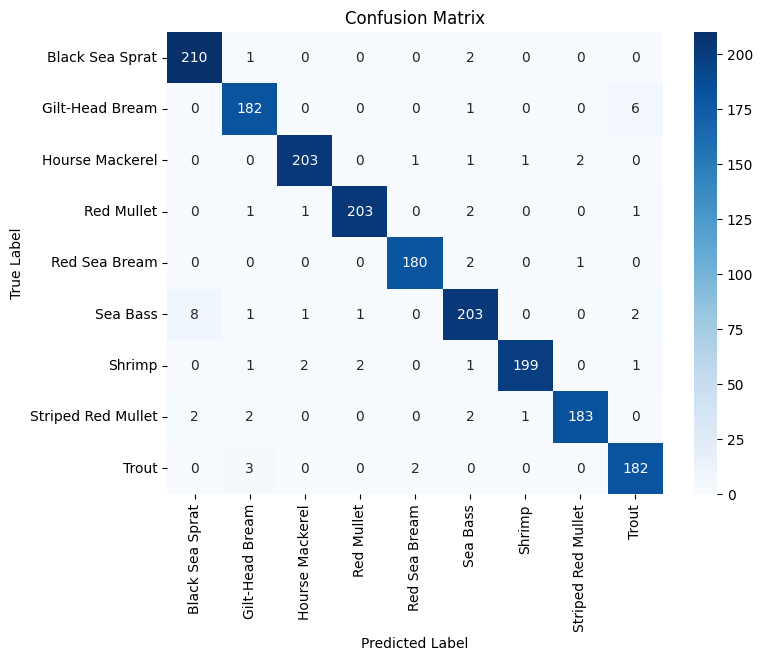

In [26]:
plt.figure(figsize=(8,6))
sns.heatmap(
    confusion_matrix(predict_data['label'], predict_data['pred']),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 9.Visualization of Testing Data

In [27]:
def plot_predictions(test_images, predictions, true_classes, num_samples=10):
   class_names = list(test_images.class_indices.keys())
   test_images.reset()
   plt.figure(figsize=(15, 8))
   
   for i in range(num_samples):
       img_batch, label_batch = next(test_images)
       img = img_batch[0]  # Batch'in ilk görüntüsü
       plt.subplot(2, 5, i + 1)
       plt.imshow(img)
       predicted_class = class_names[np.argmax(predictions[i])]
       true_class = class_names[true_classes[i]]
       color = 'green' if predicted_class == true_class else 'orange'
       plt.title(f'Actual: {true_class}\nPredict: {predicted_class}',color=color,fontsize=10)
       plt.axis('off')
   plt.tight_layout()
   plt.show()

In [28]:
plot_predictions(test_images, predictions, true_classes)

# 10.Results of Project

* The model worked successfully on the test data with 97% accuracy rate.
* Performance review was performed with model visualization.
* Actual and predicted results were compared and visualized based on test data.